# Preamble 

In [1]:
%matplotlib inline 

In [5]:
import os
# os.chdir('/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/WeakLensingDeblending/')
os.chdir('/Users/Ismael/code/lensing/WeakLensingDeblending/')

import pickle 
from tqdm import tqdm 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import mycode.tomo.tomo_fncs as tomo_fncs
import mycode.errors as errors
import mycode.preamble as preamble

In [8]:
!ls

LICENSE         descwl          fisher.py       section001.fits skeleton.py
README.md       display.py      mycode          setup.py        temp
dbquery.py      docs            notebooks       simulate.py


In [9]:
from importlib import reload
reload(tomo_fncs)
reload(errors)
reload(preamble)

<module 'mycode.preamble' from '/Users/Ismael/code/lensing/WeakLensingDeblending/mycode/preamble.py'>

In [12]:
scats = pickle.load(open('mycode/selection_cats1.p', 'rb') ,encoding='latin1')

# Functions 

In [14]:
#param is usually one of the biases. 
def get_iso_or_grp_suffix(iso_or_grp):
    suffix = ''
    if iso_or_grp == 'grp': 
        suffix = '_grp'
        
    return suffix 
    

def get_weights(args, component, iso_or_grp): 
    suffix = get_iso_or_grp_suffix(iso_or_grp)
    shape_noise = np.std(args[f'e{component}'])**2 
    weights = (shape_noise + args[f'dg{component}{suffix}']**2)**(-1)
    
    return weights 


def wmean_func(dbt, cat, component, iso_or_grp):
    assert component in ['1','2'], 'component value is not valid. '
    assert iso_or_grp in ['iso', 'grp'], 'iso_or_grp received invalied argument'
    
    suffix = get_iso_or_grp_suffix(iso_or_grp)
    weights = get_weights(args, component, iso_or_grp)
    return np.sum(weights*dbt)/np.sum(weights) 

def wmean(dbt, args, component, iso_or_grp): 
    return lambda dbt: wmean_func(dbt, args, component, iso_or_grp)


def get_error(dbt, fnc, N=1000): 
    results = boot_fnc(dbt, fnc, N)
    return np.std(results)

def boot_fnc(dbt, fnc, N=1000):
    results = [] 
    for i in range(N): 
        results.append(fnc(np.random.choice(dbt,len(dbt), replace=True)))
    return results 

def clipped_mean(dbt, p): 
    if p == 0.5: 
        return np.median(dbt)
    
    q1 = np.quantile(dbt, p)
    q2 = np.quantile(dbt, 1-p)
    cut_dbt = cut_both(dbt, q1, q2)
    mean = np.mean(cut_dbt)
    return mean 

def clipped_mean_fnc(p): 
    return lambda dbt: clipped_mean(dbt, p) 

def cut_both(dbt, cut1, cut2): 
    return dbt[(dbt>=cut1)&(dbt<=cut2)]

In [15]:
scats_small = [scats[4], scats[8]]

In [ ]:
boots = errors.bootstrap_params_cat(scats, ['e1', 'e2', 'dg1',  'dg1_grp',  'bias_g1',  'bias_g1_grp'], 1000)

10

# Weighted means scatter plot  

In [58]:
np.mean(scats[4]['bias_g1'])

-0.00050333404

In [59]:
wmean(scats[4], '1','iso')

-0.00022736157

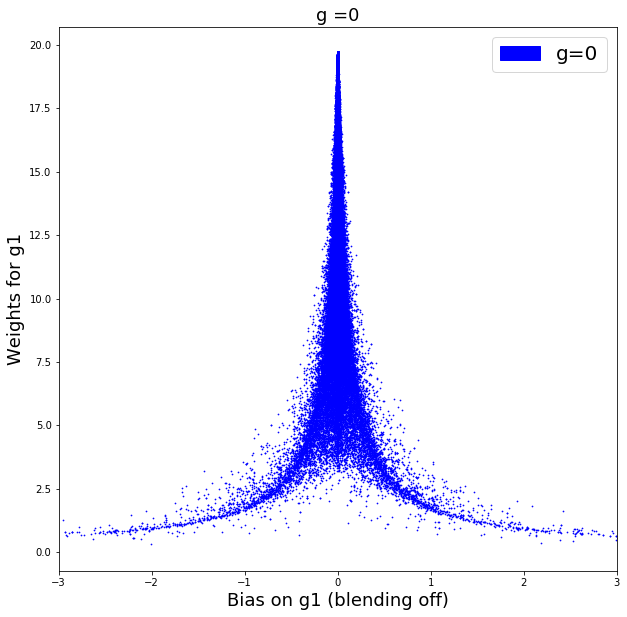

In [60]:
plt.figure(figsize=(10,10)) 
cat1 = scats[4] 
# cat2 = scats[8]
weights1 = get_weights(cat1, '1', 'iso')
# weights2 = get_weights(cat2, '1')

plt.scatter(cat1['bias_g1'], weights1, alpha=1, s=0.5, c='b')
# plt.scatter(cat2['bias_g1'], weights2, alpha=1, s=0.5, label= 'g=0.2', c= 'r')
plt.title('g =0', size = 18 )
plt.xlabel('Bias on g1 (blending off)', size=18)
plt.ylabel('Weights for g1', size=18)
plt.xlim(-3, 3)

lines = [plt.Circle((0, 0), 0.2, color='b')]
labels= ['g=0']

plt.legend(lines, labels, prop={'size':20},loc='best')



# Where does this lie in the quantile space 

In [34]:
dbt1 = scats[4]['bias_g1']
dbt2 = scats[8]['bias_g1']
ps = np.linspace(0, 0.5, 51)

In [35]:
means1 = [] 
errors1 = [] 
means2 = [] 
errors2 = [] 

In [38]:
for p in tqdm(ps): 
    means1.append(clipped_mean(dbt1, p))
    errors1.append(get_error(dbt1, clipped_mean_fnc(p), N=1000))
    
    means2.append(clipped_mean(dbt2, p))
    errors2.append(get_error(dbt2, clipped_mean_fnc(p), N=1000))

100%|██████████| 51/51 [08:46<00:00,  8.64s/it]


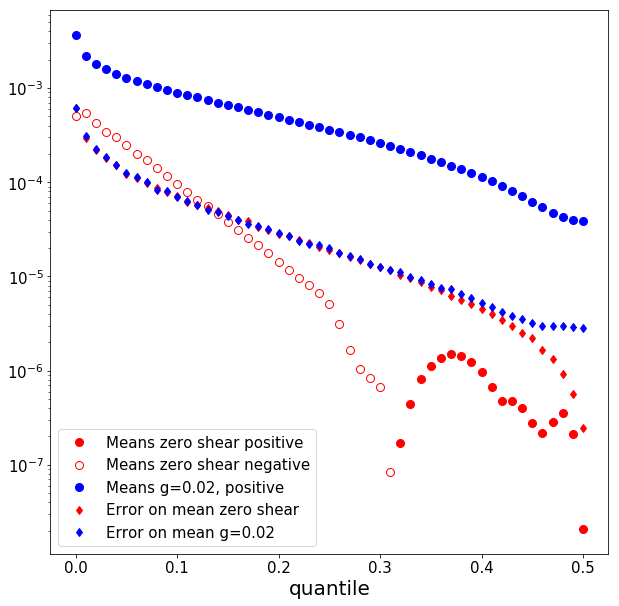

In [61]:
plt.figure(figsize=(10,10))

for p, mean in zip(ps, means1): 
    if mean > 0:
        red_dot_fill, = plt.plot(p, mean, 'ro', markersize=8)
    else: 
        red_dot_nofill, = plt.plot(p, np.absolute(mean), "o", markerfacecolor='None', color='r', markersize=8)
        


for p, mean in zip(ps, means2): 
    if mean > 0:
        blue_dot, = plt.plot(p, mean, 'bo', markersize=8)
    else: 
        plt.plot(p, np.absolute(mean), 'bx', markersize=8)
        

        
red_diamonds, = plt.plot(ps, errors1, 'rd', label= 'error of mean g=0')
blue_diamonds, = plt.plot(ps, errors2, 'bd', label= 'error of means g=0.02')

plt.legend([red_dot_fill, red_dot_nofill, blue_dot, red_diamonds, blue_diamonds], 
           ["Means zero shear positive", "Means zero shear negative", "Means g=0.02, positive", "Error on mean zero shear", "Error on mean g=0.02"], prop={"size":15})

        
plt.xlabel('quantile', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.yscale('log')